In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

pd.options.display.max_columns = None

from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [2]:
df = pd.read_csv('conversion_data_train.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [3]:
print(df.describe(include='all'))
display(100*df.isnull().sum()/df.shape[0])

       country            age       new_user  source  total_pages_visited  \
count   284580  284580.000000  284580.000000  284580        284580.000000   
unique       4            NaN            NaN       3                  NaN   
top         US            NaN            NaN     Seo                  NaN   
freq    160124            NaN            NaN  139477                  NaN   
mean       NaN      30.564203       0.685452     NaN             4.873252   
std        NaN       8.266789       0.464336     NaN             3.341995   
min        NaN      17.000000       0.000000     NaN             1.000000   
25%        NaN      24.000000       0.000000     NaN             2.000000   
50%        NaN      30.000000       1.000000     NaN             4.000000   
75%        NaN      36.000000       1.000000     NaN             7.000000   
max        NaN     123.000000       1.000000     NaN            29.000000   

            converted  
count   284580.000000  
unique            NaN  
top

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

C:\Users\jerem\AppData\Local\Temp\ipykernel_18408\804281636.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_sample.corr().round(2)


<AxesSubplot: >

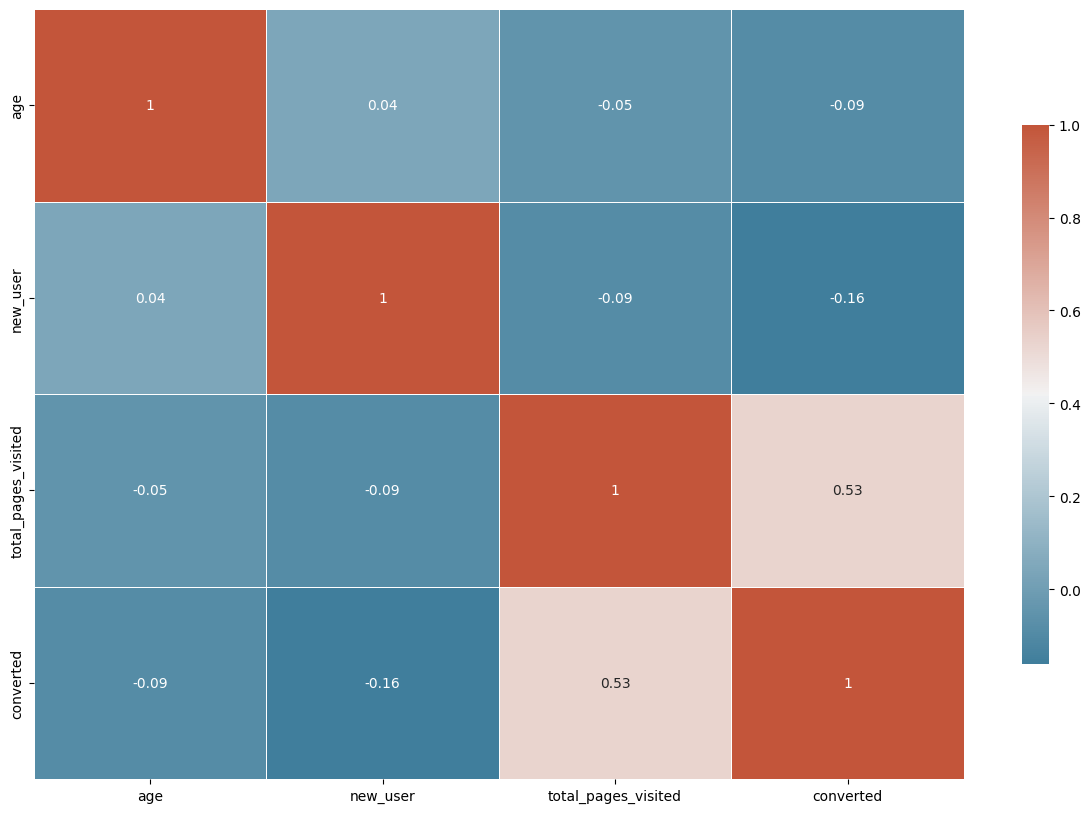

In [4]:
# correlation matrix 
df_sample = df.sample(10000)
corr = df_sample.corr().round(2)
f, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap, cbar_kws={"shrink": .7}, linewidths=.5)

In [5]:
# target evaluation, it is necessary to exceed 97% for a minimum correct model
df['converted'].value_counts(normalize=True)

0    0.967742
1    0.032258
Name: converted, dtype: float64

## test of the model on the variable with the best correlation

In [6]:
features_list = ['total_pages_visited']
target_variable = "converted"
X = df.loc[:,features_list]
Y = df.loc[:,target_variable]

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [8]:
featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
classifier = LogisticRegression() 
classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
X_test = featureencoder.transform(X_test)
Y_test_pred = classifier.predict(X_test)

## performance

In [9]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6938517686692869
f1-score on test set :  0.7060240963855423


## model selection and hyperparameterization

In [10]:
target_name = "converted"
X = df.drop(target_name , axis=1)
Y = df.loc[:,target_variable]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0, stratify=Y)

In [11]:
numeric_features = [1, 2, 4]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
categorical_features = [0, 3]
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [12]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [13]:
logistic_regression = LogisticRegression()
random_forest = RandomForestClassifier()
xgb = XGBClassifier()
sgd = SGDClassifier()
adaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [14]:
# several models without hyperparameter
logistic_regression.fit(X_train, Y_train)
Y_train_pred = logistic_regression.predict(X_train)
Y_test_pred = logistic_regression.predict(X_test)
print(f"F1 Score for the LogisticRegression model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the LogisticRegression lodel on test set: {f1_score(Y_test, Y_test_pred)}\n")

random_forest.fit(X_train, Y_train)
Y_train_pred = random_forest.predict(X_train)
Y_test_pred = random_forest.predict(X_test)
print(f"F1 Score for the RandomForestClassifier model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the RandomForestClassifier model on test set: {f1_score(Y_test, Y_test_pred)}\n")

xgb.fit(X_train, Y_train)
Y_train_pred = xgb.predict(X_train)
Y_test_pred = xgb.predict(X_test)
print(f"F1 Score for the xgb model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the xgb model on test set: {f1_score(Y_test, Y_test_pred)}\n")

sgd.fit(X_train, Y_train)
Y_train_pred = sgd.predict(X_train)
Y_test_pred = sgd.predict(X_test)
print(f"F1 Score for the sgd model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the sgd model on test set: {f1_score(Y_test, Y_test_pred)}\n")

adaBoost.fit(X_train, Y_train)
Y_train_pred = adaBoost.predict(X_train)
Y_test_pred = adaBoost.predict(X_test)
print(f"F1 Score for the adaBoost model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the adaBoost model on test set: {f1_score(Y_test, Y_test_pred)}\n")

F1 Score for the LogisticRegression model on train set: 0.7662243667068757
F1 Score for the LogisticRegression lodel on test set: 0.755190729116369

F1 Score for the RandomForestClassifier model on train set: 0.8084632516703786
F1 Score for the RandomForestClassifier model on test set: 0.7339537103316631

F1 Score for the xgb model on train set: 0.7781870595771941
F1 Score for the xgb model on test set: 0.7486194477791117

F1 Score for the sgd model on train set: 0.7649331830623087
F1 Score for the sgd model on test set: 0.7554269175108538



c:\Users\jerem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


F1 Score for the adaBoost model on train set: 0.80736
F1 Score for the adaBoost model on test set: 0.7235987490979071



## adjust the hyperparameters

In [15]:
random_forest = RandomForestClassifier(max_depth= 10, min_samples_split=10, n_estimators= 150,  min_samples_leaf=10)
random_forest.fit(X_train, Y_train)
Y_train_pred = random_forest.predict(X_train)
Y_test_pred = random_forest.predict(X_test)
print(f"F1 Score for the Random Forest model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the Random Forest model on test set: {f1_score(Y_test, Y_test_pred)}")

scores_df = pd.DataFrame(columns = ['model', 'f1_score', 'set'])
scores_df = scores_df.append({'model': 'Random_Forest', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'Random_Forest', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

F1 Score for the Random Forest model on train set: 0.7735651613941883
F1 Score for the Random Forest model on test set: 0.7484899734235324


C:\Users\jerem\AppData\Local\Temp\ipykernel_18408\1758034022.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'Random_Forest', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\jerem\AppData\Local\Temp\ipykernel_18408\1758034022.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'Random_Forest', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1_score,set
0,Random_Forest,0.773565,train
1,Random_Forest,0.748490,test


In [16]:
logistic_regression = LogisticRegression(penalty='l2', C=1,  intercept_scaling=1, max_iter=1000)
logistic_regression.fit(X_train, Y_train)
Y_train_pred = logistic_regression.predict(X_train)
Y_test_pred = logistic_regression.predict(X_test)

print(f"F1 Score for the Logistic Regression model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the Logistic Regression model on test set: {f1_score(Y_test, Y_test_pred)}")

scores_df = scores_df.append({'model': 'Logistic_Regression', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'Logistic_Regression', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

F1 Score for the Logistic Regression model on train set: 0.7662243667068757
F1 Score for the Logistic Regression model on test set: 0.755190729116369


C:\Users\jerem\AppData\Local\Temp\ipykernel_18408\91242039.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'Logistic_Regression', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\jerem\AppData\Local\Temp\ipykernel_18408\91242039.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'Logistic_Regression', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1_score,set
0,Random_Forest,0.773565,train
1,Random_Forest,0.748490,test
2,Logistic_Regression,0.766224,train
3,Logistic_Regression,0.755191,test


In [17]:
xgb = XGBClassifier(base_score=0.5,booster="gbtree", colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0, max_depth=1, min_child_weight=10,
                    n_estimators=150, nthread=1, objective='binary:logistic', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,silent=True, subsample=0.5, verbosity=0)

xgb.fit(X_train, Y_train)
Y_train_pred = xgb.predict(X_train)
Y_test_pred = xgb.predict(X_test)

print(f"F1 Score for the XGBClassifier  model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the XGBClassifier  model on test set: {f1_score(Y_test, Y_test_pred)}\n")

scores_df = scores_df.append({'model': 'XGBClassifier', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'XGBClassifier', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

F1 Score for the XGBClassifier  model on train set: 0.7663776493256262
F1 Score for the XGBClassifier  model on test set: 0.7557581573896353



C:\Users\jerem\AppData\Local\Temp\ipykernel_18408\2174829491.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'XGBClassifier', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\jerem\AppData\Local\Temp\ipykernel_18408\2174829491.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'XGBClassifier', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1_score,set
0,Random_Forest,0.773565,train
1,Random_Forest,0.748490,test
2,Logistic_Regression,0.766224,train
3,Logistic_Regression,0.755191,test
4,XGBClassifier,0.766378,train
5,XGBClassifier,0.755758,test


In [18]:
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, 
                    verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, 
                    validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
                    
sgd.fit(X_train, Y_train)
Y_train_pred = sgd.predict(X_train)
Y_test_pred = sgd.predict(X_test)

print(f"F1 Score for the SGDClassifier model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the SGDClassifier model on test set: {f1_score(Y_test, Y_test_pred)}")

scores_df = scores_df.append({'model': 'SGDClassifier', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'SGDClassifier', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

F1 Score for the SGDClassifier model on train set: 0.7714242607121304
F1 Score for the SGDClassifier model on test set: 0.7624408916910606


C:\Users\jerem\AppData\Local\Temp\ipykernel_18408\725431326.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'SGDClassifier', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\jerem\AppData\Local\Temp\ipykernel_18408\725431326.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'SGDClassifier', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1_score,set
0,Random_Forest,0.773565,train
1,Random_Forest,0.748490,test
2,Logistic_Regression,0.766224,train
3,Logistic_Regression,0.755191,test
4,XGBClassifier,0.766378,train
5,XGBClassifier,0.755758,test
6,SGDClassifier,0.771424,train
7,SGDClassifier,0.762441,test


In [19]:
adaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

parameters = {'base_estimator__max_depth':[4],
              'base_estimator__min_samples_leaf':[5],
              'n_estimators':[1000],
              'learning_rate':[0.01]}

grid_ada = GridSearchCV(adaBoost, parameters,verbose=3,scoring='f1',n_jobs=-1)

grid_ada.fit(X_train, Y_train)
Y_train_pred = grid_ada.predict(X_train)
Y_test_pred = grid_ada.predict(X_test)

print(f"F1 Score for the AdaBoostClassifier model on train set: {f1_score(Y_train, Y_train_pred)}")
print(f"F1 Score for the AdaBoostClassifier model on test set: {f1_score(Y_test, Y_test_pred)}")

scores_df = scores_df.append({'model': 'AdaBoostClassifier', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'AdaBoostClassifier', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)
scores_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\jerem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


F1 Score for the AdaBoostClassifier model on train set: 0.7683388356550447
F1 Score for the AdaBoostClassifier model on test set: 0.7525997581620315


C:\Users\jerem\AppData\Local\Temp\ipykernel_18408\1459870305.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'AdaBoostClassifier', 'f1_score': f1_score(Y_train, Y_train_pred), 'set': 'train'}, ignore_index = True)
C:\Users\jerem\AppData\Local\Temp\ipykernel_18408\1459870305.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'model': 'AdaBoostClassifier', 'f1_score': f1_score(Y_test, Y_test_pred), 'set': 'test'}, ignore_index = True)


,model,f1_score,set
0,Random_Forest,0.773565,train
1,Random_Forest,0.748490,test
2,Logistic_Regression,0.766224,train
3,Logistic_Regression,0.755191,test
4,XGBClassifier,0.766378,train
5,XGBClassifier,0.755758,test
6,SGDClassifier,0.771424,train
7,SGDClassifier,0.762441,test
8,AdaBoostClassifier,0.768339,train
9,AdaBoostClassifier,0.752600,test


In [20]:
px.bar(scores_df, x="model", y='f1_score', color='set', barmode='group', width=900)

## the best model on the f1 score is the SGD

In [21]:
X_full = np.append(X_train,X_test,axis=0)
Y_full = np.append(Y_train,Y_test)


In [22]:
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, 
                    shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, 
                    power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
                    
sgd.fit(X_full, Y_full)

SGDClassifier()

In [23]:
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

Prediction set (without labels) : (31620, 5)


In [24]:
columns = ["country", "age", "new_user", "source", "total_pages_visited"]
data_without_labels = data_without_labels.loc[:, columns]
data_without_labels = data_without_labels.values
X_without_labels = preprocessor.transform(data_without_labels)

c:\Users\jerem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:409: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\jerem\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:409: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



In [25]:
data = {
    'converted': xgb.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_jeremy.csv', index=False)